In [5]:
import numpy as np 
from tqdm import tqdm
import cv2
import os
import shutil
import itertools
import imutils
import matplotlib.pyplot as plt
from IPython.display import clear_output
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix

import plotly.graph_objs as go
from plotly.offline import init_notebook_mode, iplot
from plotly import tools

from keras.preprocessing.image import ImageDataGenerator
from keras.applications.vgg16 import VGG16, preprocess_input
from keras import layers
from keras.models import Model, Sequential
from keras.optimizers import Adam, RMSprop
from keras.callbacks import EarlyStopping

# To remove deprecated warnings from the tensorflow
import warnings
warnings.filterwarnings("ignore")

init_notebook_mode(connected=True)
RANDOM_SEED = 123

In [9]:
IMG_PATH = 'brain_tumor_dataset/'
# split the data by train/val/test
for CLASS in os.listdir(IMG_PATH):
    if not CLASS.startswith('.'):
        IMG_NUM = len(os.listdir(IMG_PATH + CLASS))
        for (n, FILE_NAME) in enumerate(os.listdir(IMG_PATH + CLASS)):
            img = IMG_PATH + CLASS + '/' + FILE_NAME
            if n < 5:
                shutil.copy(img, 'TEST/' + CLASS.upper() + '/' + FILE_NAME)
            elif n < 0.8*IMG_NUM:
                shutil.copy(img, 'TRAIN/'+ CLASS.upper() + '/' + FILE_NAME)
            else:
                shutil.copy(img, 'VAL/'+ CLASS.upper() + '/' + FILE_NAME)

In [11]:
def load_data(dir_path, img_size=(100,100)):
    """
    Load resized images as np.arrays to workspace
    """
    X = []
    y = []
    i = 0
    labels = dict()
    for path in tqdm(sorted(os.listdir(dir_path))):
        if not path.startswith('.'):
            labels[i] = path
            for file in os.listdir(dir_path + path):
                if not file.startswith('.'):
                    img = cv2.imread(dir_path + path + '/' + file)
                    X.append(img)
                    y.append(i)
            i += 1
    X = np.array(X)
    y = np.array(y)
    print(f'{len(X)} images loaded from {dir_path} directory.')
    return X, y, labels

In [12]:
TRAIN_DIR = 'TRAIN/'
TEST_DIR = 'TEST/'
VAL_DIR = 'VAL/'
IMG_SIZE = (224,224)

# use predefined function to load the image data into workspace
X_train, y_train, labels = load_data(TRAIN_DIR, IMG_SIZE)
X_test, y_test, _ = load_data(TEST_DIR, IMG_SIZE)
X_val, y_val, _ = load_data(VAL_DIR, IMG_SIZE)

100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:01<00:00,  1.47it/s]


193 images loaded from TRAIN/ directory.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00, 23.32it/s]


10 images loaded from TEST/ directory.


100%|████████████████████████████████████████████████████████████████████████████████████| 2/2 [00:00<00:00,  3.11it/s]


50 images loaded from VAL/ directory.


In [20]:
y = dict()
y[0] = []
y[1] = []
for set_name in (y_train, y_val, y_test):
    y[0].append(np.sum(set_name == 0))
    y[1].append(np.sum(set_name == 1))

trace0 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[0],
    name='No',
    marker=dict(color='#33cc33'),
    opacity=0.7
)
trace1 = go.Bar(
    x=['Train Set', 'Validation Set', 'Test Set'],
    y=y[1],
    name='Yes',
    marker=dict(color='#ff3300'),
    opacity=0.7
)
data = [trace0, trace1]
layout = go.Layout(
    title='Count of classes in each set',
    xaxis={'title': 'Set'},
    yaxis={'title': 'Count'}
)
fig = go.Figure(data, layout)
iplot(fig)

In [21]:
def plot_samples(X, y, labels_dict, n=50):
    """
    Creates a gridplot for desired number of images (n) from the specified set
    """
    for index in range(len(labels_dict)):
        imgs = X[np.argwhere(y == index)][:n]
        j = 10
        i = int(n/j)

        plt.figure(figsize=(15,6))
        c = 1
        for img in imgs:
            plt.subplot(i,j,c)
            plt.imshow(img[0])

            plt.xticks([])
            plt.yticks([])
            c += 1
        plt.suptitle('Tumor: {}'.format(labels_dict[index]))
        plt.show()

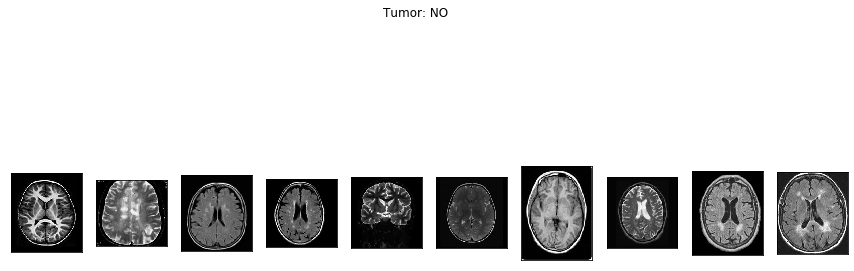

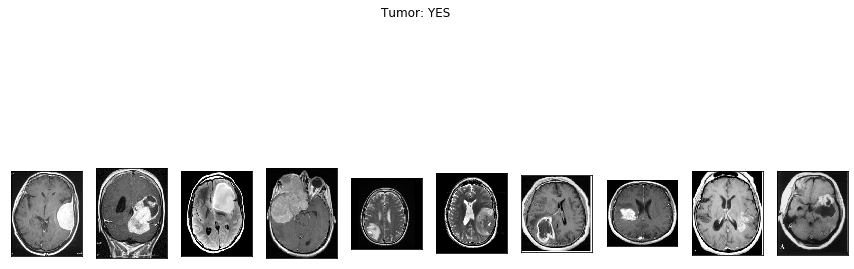

In [22]:
plot_samples(X_train, y_train, labels, 10)

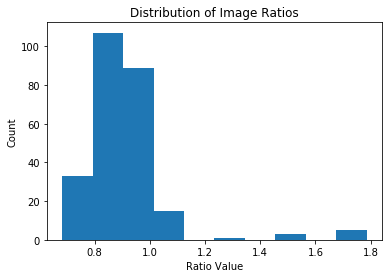

In [23]:
RATIO_LIST = []
for set in (X_train, X_test, X_val):
    for img in set:
        RATIO_LIST.append(img.shape[1]/img.shape[0])
        
plt.hist(RATIO_LIST)
plt.title('Distribution of Image Ratios')
plt.xlabel('Ratio Value')
plt.ylabel('Count')
plt.show()

The first step of "normalization" would be to crop the brain out of the images. I used technique which was perfectly described in pyimagesearch blog(https://www.pyimagesearch.com/2016/04/11/finding-extreme-points-in-contours-with-opencv/)

In [24]:
def crop_imgs(set_name, add_pixels_value=0):
    """
    Finds the extreme points on the image and crops the rectangular out of them
    """
    set_new = []
    for img in set_name:
        gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
        gray = cv2.GaussianBlur(gray, (5, 5), 0)

        # threshold the image, then perform a series of erosions +
        # dilations to remove any small regions of noise
        thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
        thresh = cv2.erode(thresh, None, iterations=2)
        thresh = cv2.dilate(thresh, None, iterations=2)

        # find contours in thresholded image, then grab the largest one
        cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
        cnts = imutils.grab_contours(cnts)
        c = max(cnts, key=cv2.contourArea)

        # find the extreme points
        extLeft = tuple(c[c[:, :, 0].argmin()][0])
        extRight = tuple(c[c[:, :, 0].argmax()][0])
        extTop = tuple(c[c[:, :, 1].argmin()][0])
        extBot = tuple(c[c[:, :, 1].argmax()][0])

        ADD_PIXELS = add_pixels_value
        new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()
        set_new.append(new_img)

    return np.array(set_new)

Let's look at example what this function will do with MRI scans:

In [25]:
img = cv2.imread('brain_tumor_dataset/yes/Y108.jpg')
img = cv2.resize(img,dsize=IMG_SIZE,
            interpolation=cv2.INTER_CUBIC)

gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
gray = cv2.GaussianBlur(gray, (5, 5), 0)

# threshold the image, then perform a series of erosions +
# dilations to remove any small regions of noise
thresh = cv2.threshold(gray, 45, 255, cv2.THRESH_BINARY)[1]
thresh = cv2.erode(thresh, None, iterations=2)
thresh = cv2.dilate(thresh, None, iterations=2)

# find contours in thresholded image, then grab the largest one
cnts = cv2.findContours(thresh.copy(), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
cnts = imutils.grab_contours(cnts)
c = max(cnts, key=cv2.contourArea)

# find the extreme points
extLeft = tuple(c[c[:, :, 0].argmin()][0])
extRight = tuple(c[c[:, :, 0].argmax()][0])
extTop = tuple(c[c[:, :, 1].argmin()][0])
extBot = tuple(c[c[:, :, 1].argmax()][0])

# add contour on the image
img_cnt = cv2.drawContours(img.copy(), [c], -1, (0, 255, 255), 4)

# add extreme points
img_pnt = cv2.circle(img_cnt.copy(), extLeft, 8, (0, 0, 255), -1)
img_pnt = cv2.circle(img_pnt, extRight, 8, (0, 255, 0), -1)
img_pnt = cv2.circle(img_pnt, extTop, 8, (255, 0, 0), -1)
img_pnt = cv2.circle(img_pnt, extBot, 8, (255, 255, 0), -1)

# crop
ADD_PIXELS = 0
new_img = img[extTop[1]-ADD_PIXELS:extBot[1]+ADD_PIXELS, extLeft[0]-ADD_PIXELS:extRight[0]+ADD_PIXELS].copy()

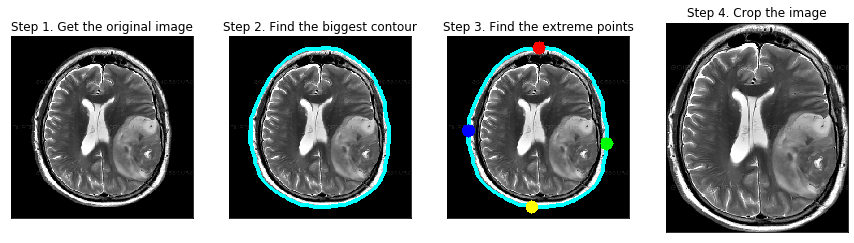

In [26]:
plt.figure(figsize=(15,6))
plt.subplot(141)
plt.imshow(img)
plt.xticks([])
plt.yticks([])
plt.title('Step 1. Get the original image')
plt.subplot(142)
plt.imshow(img_cnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 2. Find the biggest contour')
plt.subplot(143)
plt.imshow(img_pnt)
plt.xticks([])
plt.yticks([])
plt.title('Step 3. Find the extreme points')
plt.subplot(144)
plt.imshow(new_img)
plt.xticks([])
plt.yticks([])
plt.title('Step 4. Crop the image')
plt.show()

In [27]:
# apply this for each set
X_train_crop = crop_imgs(set_name=X_train)
X_val_crop = crop_imgs(set_name=X_val)
X_test_crop = crop_imgs(set_name=X_test)

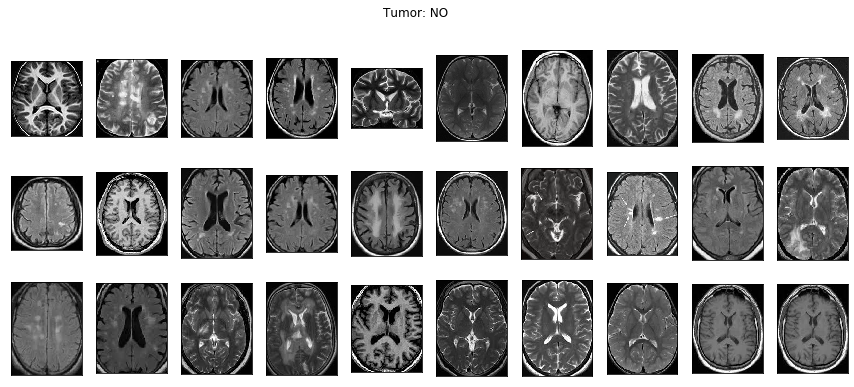

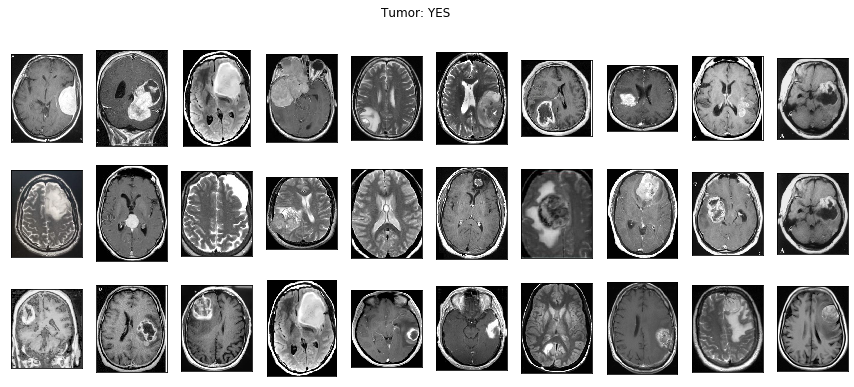

In [28]:
plot_samples(X_train_crop, y_train, labels, 30)

In [38]:
def save_new_images(x_set, y_set, folder_name):
    i = 0
    for (img, imclass) in zip(x_set, y_set):
        if imclass == 0:
            cv2.imwrite(folder_name+'NO/'+str(i)+'.jpg', img)
        else:
            cv2.imwrite(folder_name+'YES/'+str(i)+'.jpg', img)
        i += 1

In [52]:
save_new_images(X_train_crop, y_train, folder_name='TRAIN_CROP/')
save_new_images(X_val_crop, y_val, folder_name='VAL_CROP/')
save_new_images(X_test_crop, y_test, folder_name='TEST_CROP/')

In [32]:
def preprocess_imgs(set_name, img_size):
    """
    Resize and apply VGG-15 preprocessing
    """
    set_new = []
    for img in set_name:
        img = cv2.resize(
            img,
            dsize=img_size,
            interpolation=cv2.INTER_CUBIC
        )
        set_new.append(preprocess_input(img))
    return np.array(set_new)

In [33]:
X_train_prep = preprocess_imgs(set_name=X_train_crop, img_size=IMG_SIZE)
X_test_prep = preprocess_imgs(set_name=X_test_crop, img_size=IMG_SIZE)
X_val_prep = preprocess_imgs(set_name=X_val_crop, img_size=IMG_SIZE)

In [34]:
# set the paramters we want to change randomly
demo_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.05,
    height_shift_range=0.05,
    rescale=1./255,
    shear_range=0.05,
    brightness_range=[0.1, 1.5],
    horizontal_flip=True,
    vertical_flip=True)

In [35]:
os.mkdir('preview')
x = X_train_crop[0]  
x = x.reshape((1,) + x.shape) 

i = 0
for batch in demo_datagen.flow(x, batch_size=1, save_to_dir='preview', save_prefix='aug_img', save_format='jpg'):
    i += 1
    if i > 20:
        break

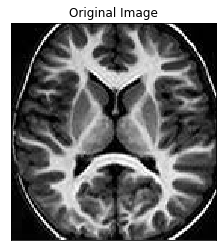

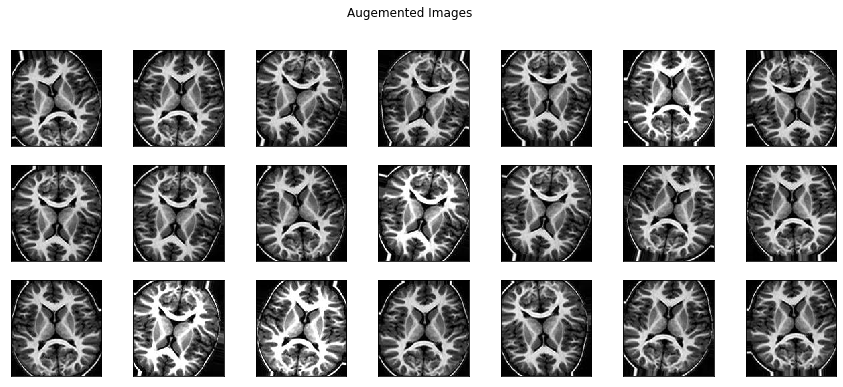

In [36]:
plt.imshow(X_train_crop[0])
plt.xticks([])
plt.yticks([])
plt.title('Original Image')
plt.show()

plt.figure(figsize=(15,6))
i = 1
for img in os.listdir('preview/'):
    img = cv2.cv2.imread('preview/' + img)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    plt.subplot(3,7,i)
    plt.imshow(img)
    plt.xticks([])
    plt.yticks([])
    i += 1
    if i > 3*7:
        break
plt.suptitle('Augemented Images')
plt.show()

In [53]:
TRAIN_DIR = 'TRAIN_CROP/'
VAL_DIR = 'VAL_CROP/'

train_datagen = ImageDataGenerator(
    rotation_range=15,
    width_shift_range=0.1,
    height_shift_range=0.1,
    shear_range=0.1,
    brightness_range=[0.5, 1.5],
    horizontal_flip=True,
    vertical_flip=True,
    preprocessing_function=preprocess_input)

test_datagen = ImageDataGenerator(
    preprocessing_function=preprocess_input)


train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=32,
    class_mode='binary',
    seed=RANDOM_SEED)


validation_generator = test_datagen.flow_from_directory(
    VAL_DIR,
    color_mode='rgb',
    target_size=IMG_SIZE,
    batch_size=16,
    class_mode='binary',
    seed=RANDOM_SEED)

Found 193 images belonging to 2 classes.
Found 50 images belonging to 2 classes.


In [54]:
# load base model

from keras.applications.vgg16 import VGG16

base_model = VGG16(include_top=False, weights='imagenet',input_shape=IMG_SIZE + (3,))

In [55]:
NUM_CLASSES = 1

model = Sequential()
model.add(base_model)
model.add(layers.Flatten())
model.add(layers.Dropout(0.5))
model.add(layers.Dense(NUM_CLASSES, activation='sigmoid'))

model.layers[0].trainable = False

model.compile(
    loss='binary_crossentropy',
    optimizer=RMSprop(lr=1e-4),
    metrics=['accuracy']
)

model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 7, 7, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 25088)             0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 25088)             0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 25089     
Total params: 14,739,777
Trainable params: 25,089
Non-trainable params: 14,714,688
_________________________________________________________________


In [57]:
%%time
EPOCHS = 30
es = EarlyStopping(
    monitor='val_acc', 
    mode='max',
    patience=6
)

history = model.fit_generator(
    train_generator,
    steps_per_epoch=50,
    epochs=EPOCHS,
    validation_data=validation_generator,
    validation_steps=25,
    callbacks=[es]
)

Epoch 1/30
50/50 [==============================] - ETA: 7:25 - loss: 5.5139 - accuracy: 0.43 - ETA: 3:43 - loss: 10.1233 - accuracy: 0.424 - ETA: 4:26 - loss: 8.2159 - accuracy: 0.507 - ETA: 4:53 - loss: 7.5537 - accuracy: 0.50 - ETA: 5:08 - loss: 7.2788 - accuracy: 0.50 - ETA: 5:13 - loss: 6.7023 - accuracy: 0.52 - ETA: 5:10 - loss: 6.5430 - accuracy: 0.53 - ETA: 5:08 - loss: 6.2194 - accuracy: 0.54 - ETA: 5:01 - loss: 5.9663 - accuracy: 0.54 - ETA: 4:52 - loss: 5.6232 - accuracy: 0.55 - ETA: 4:46 - loss: 5.3569 - accuracy: 0.57 - ETA: 4:40 - loss: 5.2356 - accuracy: 0.57 - ETA: 4:36 - loss: 5.0467 - accuracy: 0.57 - ETA: 4:10 - loss: 5.1100 - accuracy: 0.56 - ETA: 4:09 - loss: 4.9015 - accuracy: 0.57 - ETA: 4:03 - loss: 4.9979 - accuracy: 0.57 - ETA: 3:42 - loss: 4.7039 - accuracy: 0.57 - ETA: 3:39 - loss: 4.6462 - accuracy: 0.57 - ETA: 3:35 - loss: 4.6765 - accuracy: 0.57 - ETA: 3:31 - loss: 4.6491 - accuracy: 0.57 - ETA: 3:27 - loss: 4.5694 - accuracy: 0.58 - ETA: 3:22 - loss: 4.6

50/50 [==============================] - ETA: 6:03 - loss: 1.7888 - accuracy: 0.81 - ETA: 6:16 - loss: 1.3147 - accuracy: 0.82 - ETA: 6:16 - loss: 1.6152 - accuracy: 0.81 - ETA: 6:09 - loss: 1.4285 - accuracy: 0.83 - ETA: 4:51 - loss: 1.1428 - accuracy: 0.83 - ETA: 4:51 - loss: 1.1799 - accuracy: 0.83 - ETA: 4:54 - loss: 1.2291 - accuracy: 0.83 - ETA: 4:54 - loss: 1.2026 - accuracy: 0.84 - ETA: 4:56 - loss: 1.3927 - accuracy: 0.83 - ETA: 4:54 - loss: 1.2869 - accuracy: 0.84 - ETA: 4:50 - loss: 1.2501 - accuracy: 0.84 - ETA: 4:46 - loss: 1.2300 - accuracy: 0.84 - ETA: 4:40 - loss: 1.2012 - accuracy: 0.84 - ETA: 4:33 - loss: 1.1670 - accuracy: 0.84 - ETA: 4:08 - loss: 1.5970 - accuracy: 0.84 - ETA: 4:07 - loss: 1.6694 - accuracy: 0.84 - ETA: 4:01 - loss: 1.6726 - accuracy: 0.84 - ETA: 3:55 - loss: 1.6225 - accuracy: 0.84 - ETA: 3:48 - loss: 1.6718 - accuracy: 0.83 - ETA: 3:41 - loss: 1.6755 - accuracy: 0.83 - ETA: 3:24 - loss: 1.5957 - accuracy: 0.83 - ETA: 3:19 - loss: 1.5815 - accuracy

50/50 [==============================] - ETA: 7:08 - loss: 1.2170 - accuracy: 0.90 - ETA: 7:12 - loss: 1.2070 - accuracy: 0.85 - ETA: 7:05 - loss: 1.1672 - accuracy: 0.85 - ETA: 6:53 - loss: 1.3790 - accuracy: 0.85 - ETA: 6:42 - loss: 1.3176 - accuracy: 0.85 - ETA: 5:29 - loss: 1.6135 - accuracy: 0.84 - ETA: 5:30 - loss: 1.6016 - accuracy: 0.84 - ETA: 5:26 - loss: 1.4716 - accuracy: 0.84 - ETA: 5:26 - loss: 1.4049 - accuracy: 0.85 - ETA: 5:22 - loss: 1.3045 - accuracy: 0.86 - ETA: 5:17 - loss: 1.2733 - accuracy: 0.86 - ETA: 5:11 - loss: 1.2054 - accuracy: 0.86 - ETA: 5:04 - loss: 1.2169 - accuracy: 0.86 - ETA: 4:36 - loss: 1.1615 - accuracy: 0.86 - ETA: 4:30 - loss: 1.1530 - accuracy: 0.86 - ETA: 4:26 - loss: 1.1365 - accuracy: 0.86 - ETA: 4:21 - loss: 1.0951 - accuracy: 0.86 - ETA: 4:14 - loss: 1.0578 - accuracy: 0.87 - ETA: 4:08 - loss: 1.0369 - accuracy: 0.87 - ETA: 4:01 - loss: 1.0445 - accuracy: 0.87 - ETA: 3:54 - loss: 1.0676 - accuracy: 0.86 - ETA: 3:36 - loss: 1.0191 - accuracy

50/50 [==============================] - ETA: 6:59 - loss: 0.5364 - accuracy: 0.93 - ETA: 6:56 - loss: 0.9199 - accuracy: 0.90 - ETA: 6:54 - loss: 0.6908 - accuracy: 0.92 - ETA: 6:43 - loss: 0.7377 - accuracy: 0.90 - ETA: 6:20 - loss: 0.7357 - accuracy: 0.89 - ETA: 6:15 - loss: 0.7380 - accuracy: 0.89 - ETA: 5:16 - loss: 0.6326 - accuracy: 0.89 - ETA: 5:17 - loss: 0.6488 - accuracy: 0.89 - ETA: 5:13 - loss: 0.5865 - accuracy: 0.89 - ETA: 5:09 - loss: 0.6406 - accuracy: 0.90 - ETA: 5:04 - loss: 0.5980 - accuracy: 0.90 - ETA: 4:59 - loss: 0.6083 - accuracy: 0.90 - ETA: 4:53 - loss: 0.6335 - accuracy: 0.89 - ETA: 4:47 - loss: 0.6071 - accuracy: 0.89 - ETA: 4:39 - loss: 0.6104 - accuracy: 0.89 - ETA: 4:15 - loss: 0.5722 - accuracy: 0.89 - ETA: 4:10 - loss: 0.5472 - accuracy: 0.90 - ETA: 3:49 - loss: 0.5176 - accuracy: 0.90 - ETA: 3:44 - loss: 0.5051 - accuracy: 0.90 - ETA: 3:37 - loss: 0.5320 - accuracy: 0.90 - ETA: 3:31 - loss: 0.5244 - accuracy: 0.91 - ETA: 3:23 - loss: 0.5419 - accuracy

50/50 [==============================] - ETA: 5:08 - loss: 8.0796e-04 - accuracy: 1.00 - ETA: 2:36 - loss: 4.0398e-04 - accuracy: 1.00 - ETA: 3:19 - loss: 0.0755 - accuracy: 0.9692   - ETA: 3:43 - loss: 0.1720 - accuracy: 0.96 - ETA: 3:54 - loss: 0.2600 - accuracy: 0.96 - ETA: 3:13 - loss: 0.5597 - accuracy: 0.96 - ETA: 3:20 - loss: 0.6556 - accuracy: 0.93 - ETA: 3:25 - loss: 0.6345 - accuracy: 0.93 - ETA: 3:27 - loss: 0.6055 - accuracy: 0.94 - ETA: 3:26 - loss: 0.6011 - accuracy: 0.93 - ETA: 3:27 - loss: 0.5473 - accuracy: 0.93 - ETA: 3:26 - loss: 0.5190 - accuracy: 0.93 - ETA: 3:05 - loss: 0.4846 - accuracy: 0.93 - ETA: 3:03 - loss: 0.4567 - accuracy: 0.94 - ETA: 3:01 - loss: 0.5456 - accuracy: 0.93 - ETA: 2:58 - loss: 0.5536 - accuracy: 0.92 - ETA: 2:54 - loss: 0.5754 - accuracy: 0.92 - ETA: 2:52 - loss: 0.5767 - accuracy: 0.92 - ETA: 2:48 - loss: 0.5745 - accuracy: 0.92 - ETA: 2:44 - loss: 0.5782 - accuracy: 0.92 - ETA: 2:40 - loss: 0.5584 - accuracy: 0.92 - ETA: 2:35 - loss: 0.562

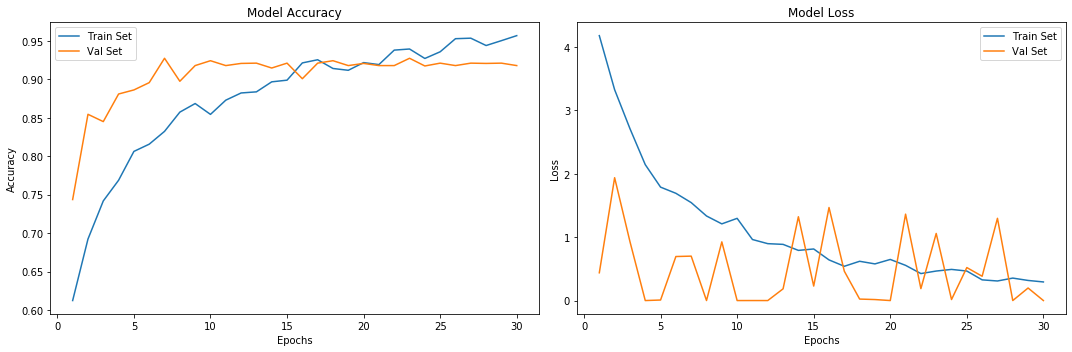

In [59]:
# plot model performance
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs_range = range(1, len(history.epoch) + 1)

plt.figure(figsize=(15,5))

plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Train Set')
plt.plot(epochs_range, val_acc, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Model Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Train Set')
plt.plot(epochs_range, val_loss, label='Val Set')
plt.legend(loc="best")
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Model Loss')

plt.tight_layout()
plt.show()

In [84]:
from keras.models import model_from_json, load_model

In [88]:
# Serialize weights to HDF5
model.save_weights("model.h5")
model.save("model.hdf5")

In [ ]:
# Load weights into new model
model.load_weights("model.h5")
loaded_model = load_model('model.hdf5')

In [89]:
# validate on val set

predictions = model.predict(X_val_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_val, predictions)
print('Val Accuracy = %.2f' % accuracy)

Val Accuracy = 0.90


In [90]:
# validate on test set
predictions = model.predict(X_test_prep)
predictions = [1 if x>0.5 else 0 for x in predictions]

accuracy = accuracy_score(y_test, predictions)
print('Test Accuracy = %.2f' % accuracy)

Test Accuracy = 1.00
